In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wrangle as w
import explore as ex
import model as m
from importlib import reload
import warnings

warnings.simplefilter('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Screaming into your Zillow
### predicting tax_value of housing from previous predictions

# Goals
- Determine driving factors of tax value of houses sold in 2016
- Use those factors to build a model to predict housing places
- Use that model to attempt to predict the tax value of houses

# Acquire
* Data acquired from CodeUp Database
* Did initial exploratory analysis within SQL.
* Identified columns with minimal null values which showed promise for modeling.
* Before cleaning, data had 52442 rows and 8 columns (See Data Dictionary for columns selected)
* Each row represents a property which had a prediction run by Zillow's model
* Each column represents a feature of that property

# Prepare
### Preparation actions:
- dropped null values in `calc_sqft, tax_value` and `year_built`
- removed homes with 0 bedrooms or bathrooms. That's not a house, that's a shed.
- filled `NaN` values (~in `full_baths` with rounded-down `bath_count` (most houses only have one half bath).
- engineered `half_baths` column as `bath_count - full_baths`
- changed data types to from floating point to integer as appropriate
- Removed Outliers, including houses with more than 8 bathrooms, 7 bathrooms, 7 half baths, or which had a valuation over $3,500,000. These values were chosen to limit data loss
- I then scaled the data using a RobustScaler to improve model performance
- final data contains 51,612 rows and 

In [2]:
reload(w)
zillow_df = w.wrangle_zillow()
train,validate,test = w.tvt_split(zillow_df)
x = ['bed_count','full_baths','half_baths','calc_sqft','year_built','fips']
y = ['tax_value']
scaled_train, validate,test = w.scale_data(train,validate,test,x)


# Explore
## A look at the data:

In [3]:
train.head()

,tax_value,bed_count,full_baths,calc_sqft,year_built,fips,half_baths
10451,761864.0,3,3,2306.0,1956,6037,0
26779,86730.0,4,2,1925.0,1965,6037,0
24645,680233.0,4,3,2728.0,1989,6111,0
26698,1609668.0,4,5,4366.0,2005,6037,0
30021,2365532.0,3,3,2313.0,1976,6059,0


In [4]:
train.describe()

,tax_value,bed_count,full_baths,calc_sqft,year_built,fips,half_baths
count,2.886500e+04,28865.000000,28865.000000,28865.000000,28865.000000,28865.000000,28865.000000
mean,4.827671e+05,3.281864,2.210220,1884.047116,1963.236134,6048.936601,0.127767
std,4.590576e+05,0.901249,0.936051,902.210633,22.965098,20.799446,0.337654
min,9.242000e+03,1.000000,1.000000,300.000000,1882.000000,6037.000000,0.000000
25%,1.890520e+05,3.000000,2.000000,1261.000000,1950.000000,6037.000000,0.000000
50%,3.690000e+05,3.000000,2.000000,1644.000000,1960.000000,6037.000000,0.000000
75%,6.040730e+05,4.000000,3.000000,2279.000000,1979.000000,6059.000000,0.000000
max,3.499594e+06,6.000000,10.000000,10686.000000,2016.000000,6111.000000,3.000000


## Is there a linear correlation between calculated square feet and tax value?

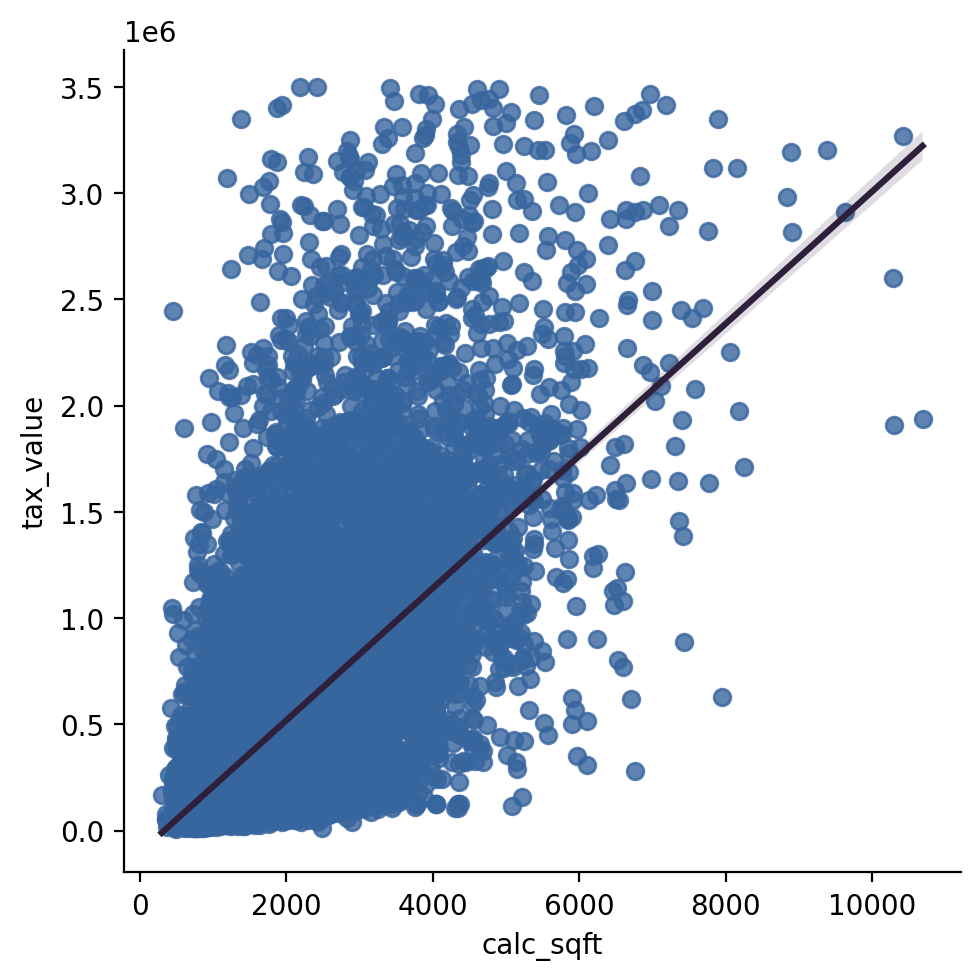

In [5]:
reload(ex)
ex.plot_1(train)

## Is there a linear correlation between tax_value and calc_sqft?
$H_0$: There is no linear correlations between tax_value and calc_sqft

$H_a$ There is a linear correlation between tax_value and calc_sqft

In [6]:
ex.tax_sqft_test(train)

## r = 0.5186105909269711

## p = 0.0

## Because $\alpha$ > p,we  reject $H_0$

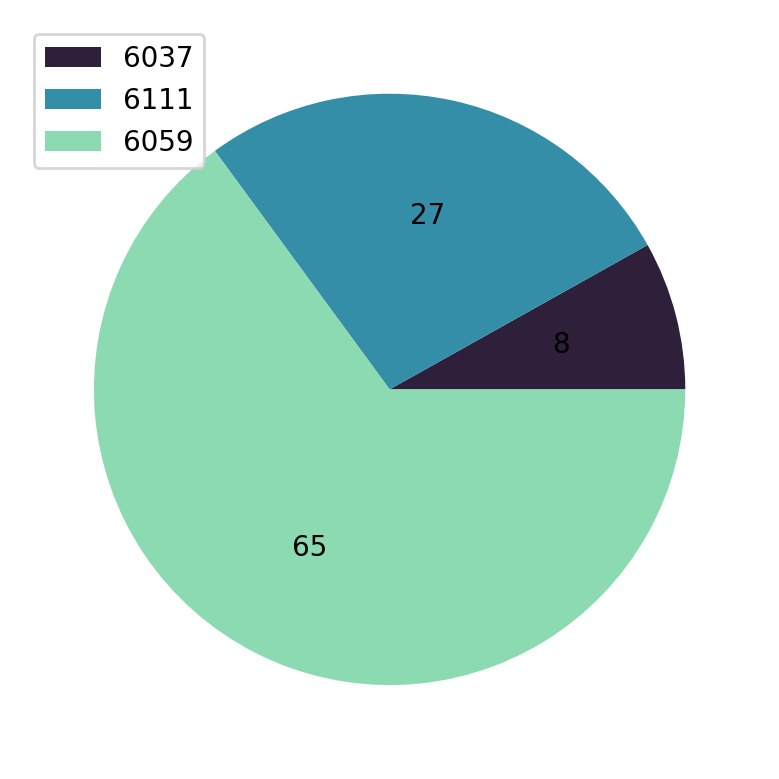

In [7]:
reload(ex)
ex.obligatory_pie_chart(train)

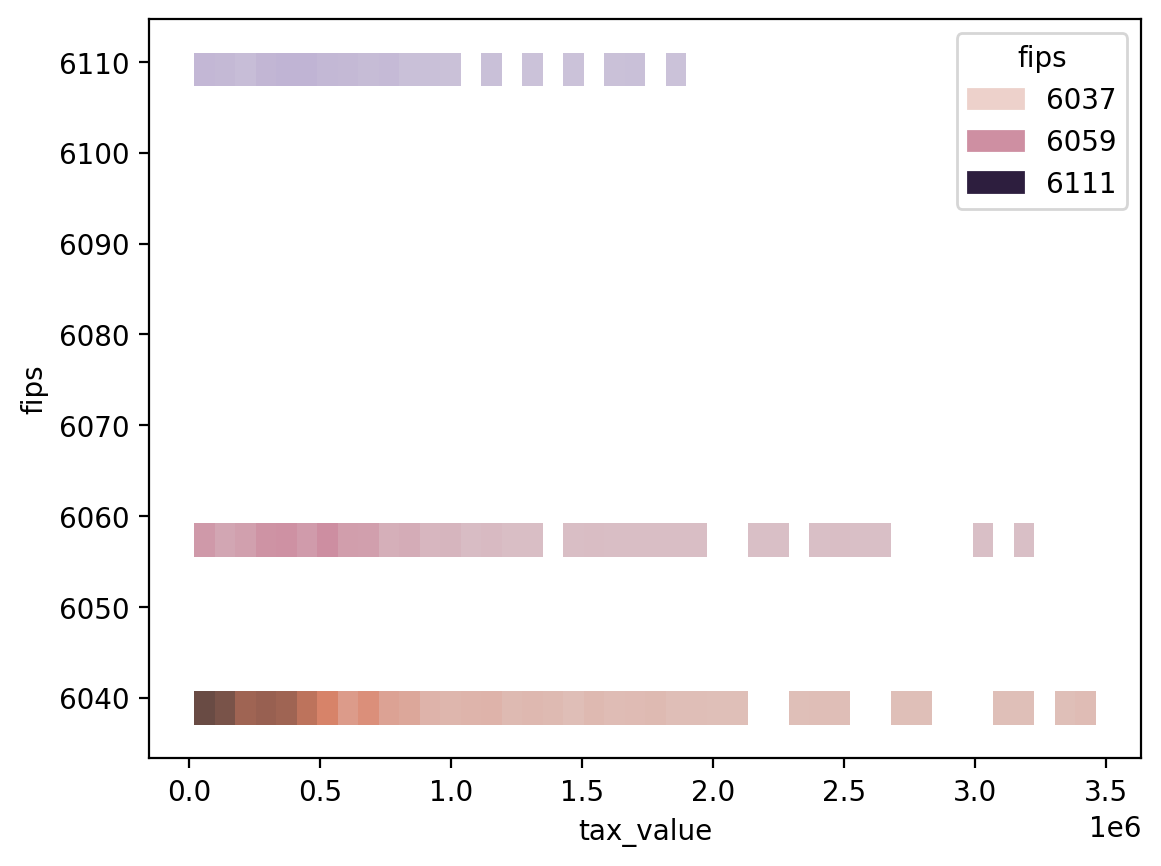

In [8]:
reload(ex)
ex.fips_graph(train.sample(frac=.05))

## Question does fips code affect tax_value

$H_0$: $\mu_{6037}= \mu_{6059} = \mu_{6111}$


$H_0$: $\mu_{6037} \neq \mu_{6059} \neq \mu_{6111}$

### Assumptions:
- Independent Samples: Yes
- Normal Distribution: No, however there is a large enough sample size that Central Limit Theorem kicks in.
- Equal Variance: Let's find out!

$H_0$: $\sigma^{2}_{6037} = \sigma^{2}_{6059} = \sigma^{2}_{6111}$

$H_a$: $\sigma^{2}_{6037} \neq \sigma^{2}_{6059} \neq \sigma^{2}_{6111}$

In [9]:
reload(ex)
ex.levene_test(train)

## t = 29.64733148428242 

 ## p = 1.37257304072837e-13 

## Because t > 0 and $\alpha$ > p,we  reject $H_0$

### Because we reject the null hypothesis, we must use the non-parametric test (Kruskal-Wallace)


In [10]:
ex.fips_v_tax(train)

## t = 1037.1424493846093 

 ## p = 6.128845059894668e-226 

## Because t > 0 and $\alpha$ > p,we  reject $H_0$

## Question: does the number of bedrooms affect the tax value

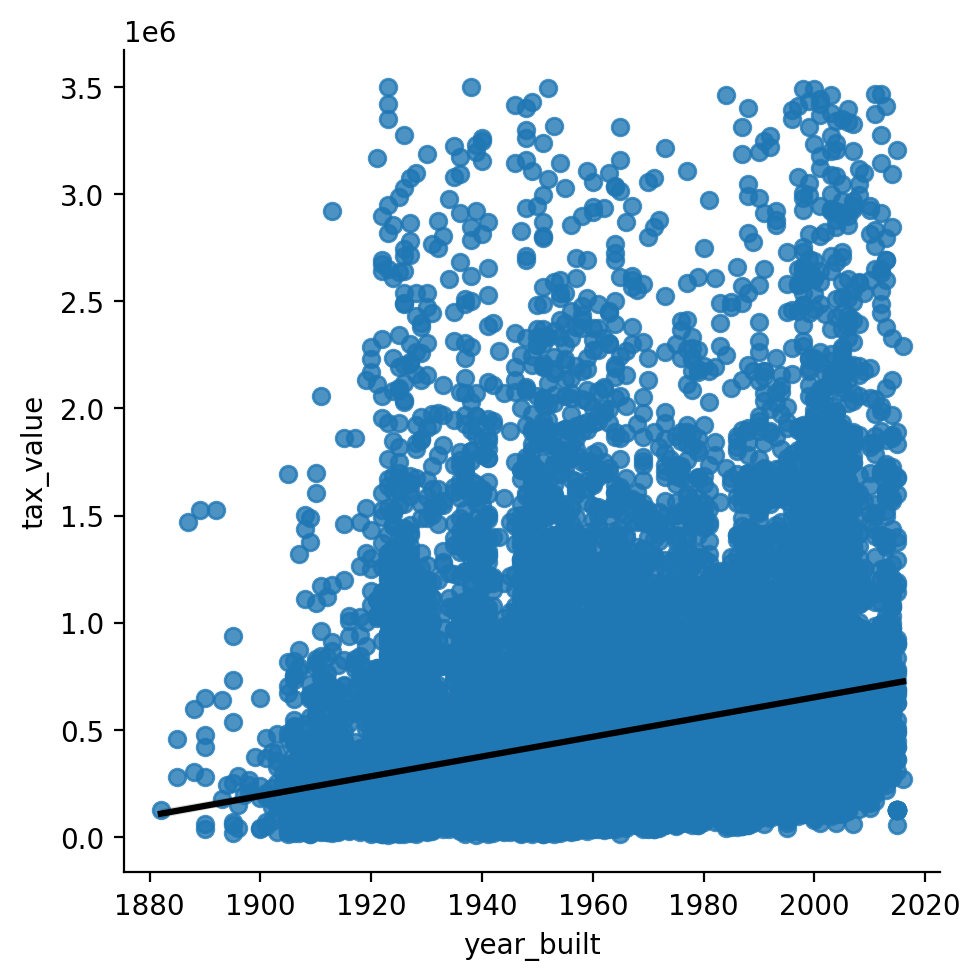

In [11]:
reload(ex)
ex.year_v_tax_value(train)


# Modeling
- For modeling, I selected 3 model types
    - Linear Regression
    - LASSO-LARS
    - Generalized Linear Model (GLM)

In [12]:
x = ['fips','calc_sqft','bed_count']
x_rfe = ['fips','calc_sqft','bed_count','half_baths',\
    'full_baths','year_built']
y = ['tax_value']
xtrain = scaled_train[x]
ytrain = scaled_train[y]
xtrain_rfe = scaled_train[x_rfe]
xvalid = validate[x]
yvalid = validate[y]


In [47]:
m.select_baseline(train.tax_value)

|                 |          SSE |         MSE |   RMSE |
|:----------------|-------------:|------------:|-------:|
| Mean Baseline   | -9.02684e-06 | 2.10727e+11 | 459050 |
| Median Baseline |  3.28389e+09 | 2.2367e+11  | 472937 |
### Because mean outperformed median on all metrics, we will use mean as our baseline

In [40]:
reload(m)
eval, winner = m.evaluate_models(xtrain,ytrain,xvalid,yvalid)
eval

| Methodology                      |   Train RMSE |   Validate RMSE |
|:---------------------|-------------:|----------------:|
| Baseline             |       459050 |          453851 |
| Linear Regression    |       358344 |          355006 |
| LASSO LARS           |       358347 |          354984 |
| General Linear Model |       423053 |          417455 |

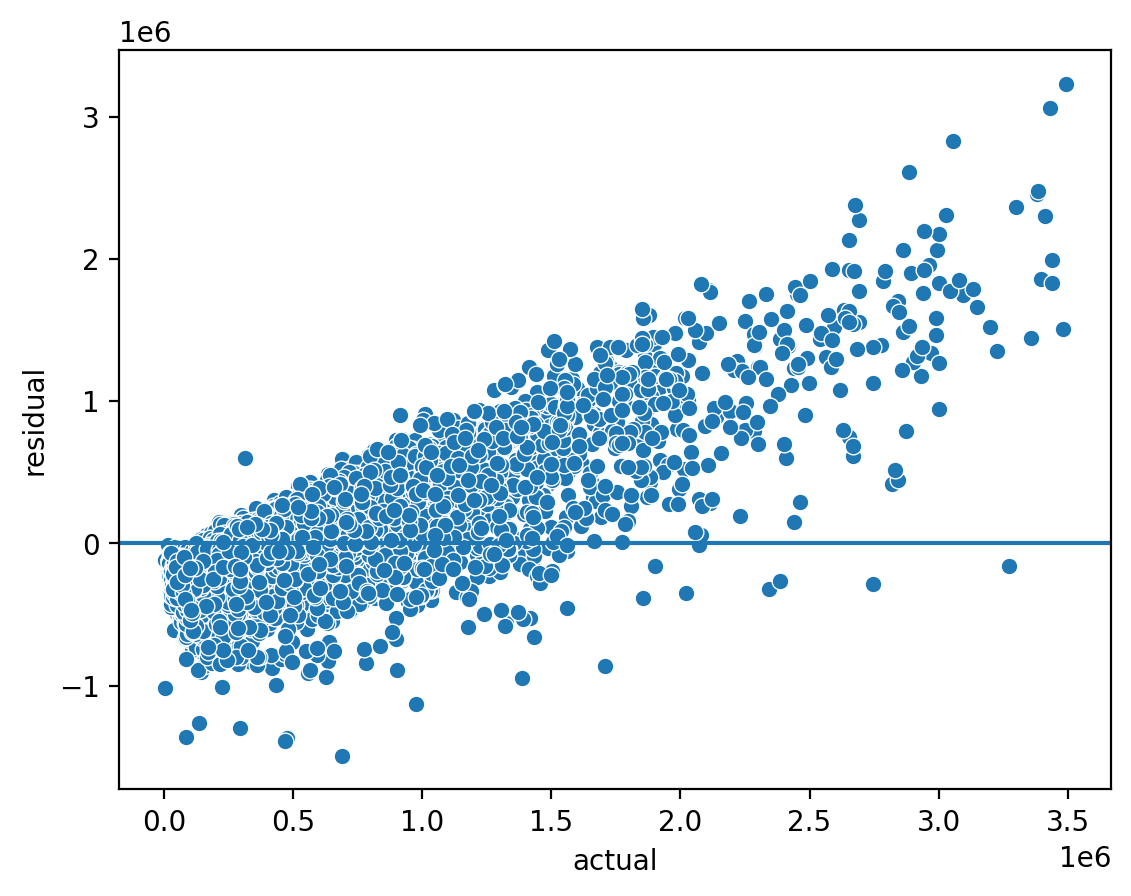

### Mean Squared Error: 347525.85

In [50]:
reload(m)
m.run_test(winner,test[x],test[y])

# Conclusions
## Exploration
- Calculated Square Feet is the most significant predictor of Tax Value vs previous predictions
- Bedroom Count and FIPS code were also predictors, but to a lesser degree.
## Modeling
- The final model of LASSO + LARS
- The final model also outperformed the baseline both in and out of sample.

## Next Steps
- broaden predictions tested on to include 2016 data
- Additional data verification.
- Use a classifier model to separate by valu`e
- Formal removal of outliers.